In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [2]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 2us/step


In [5]:
print('train data', train_data.shape)
print('test data', test_data.shape)

train data (404, 13)
test data (102, 13)


In [6]:
# Preparing the data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)

test_data -= mean
test_data /= std

In [7]:
# Building the network
from keras import models
from keras import layers


def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


In [8]:
# Validating the approach using k-fold validation
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [10]:
all_scores

[2.360334873199463, 2.5661630630493164, 3.131373882293701, 3.718198299407959]

In [11]:
np.mean(all_scores)

2.94401752948761

In [12]:
from keras import backend as K

# Some memory clean-up
K.clear_session()


In [20]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['mae']
    all_mae_histories.append(mae_history)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [19]:
history.history

{'val_loss': [76.27602789910078,
  57.570673281852486,
  47.28009034074569,
  46.219303654539075,
  30.466817572451397,
  33.70835749404782,
  29.52922337701069,
  25.96103602496787,
  26.931885017155864,
  54.79733687322034,
  25.426389778123955,
  37.292023085979835,
  50.04550689013472,
  22.838592454938606,
  40.47700392730571,
  37.4667995009977,
  34.279430062436305,
  23.41524165679858,
  29.623365470240213,
  24.576765004275707,
  17.541364766749563,
  21.79285752527977,
  20.757981324503845,
  23.322511837752316,
  26.504585302628502,
  18.611420779424435,
  19.20913938154457,
  19.364310559004057,
  28.341786757710917,
  11.77486305844297,
  18.685758307026312,
  17.706538335164307,
  22.845507630183924,
  16.49521749009007,
  17.637996714627015,
  23.505148923703576,
  9.121485847121653,
  14.762817490615394,
  14.053420457629935,
  18.8257096057284,
  13.430211599770988,
  13.722373239572839,
  22.384355310100283,
  12.642764869470838,
  17.05649777560375,
  14.475059759738

In [21]:
# Calculate the average of the per-epoch MAE scores for all folds
average_mae_history =[np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

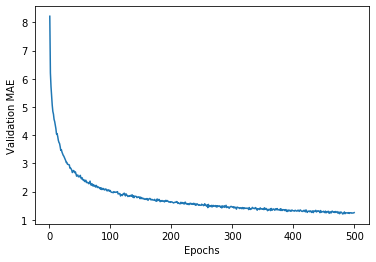

In [22]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


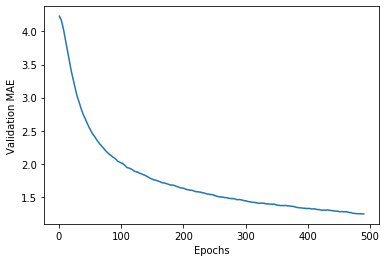

In [23]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points


smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


In [24]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)


102/102 [==============================] - 0s 147us/step


In [25]:
test_mae_score

18.32109832763672